In [1]:
import os, sys
parentdir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.join(os.getcwd(), 'example_lin_elasticity_spikeslab.ipynb'))))
sys.path.append(parentdir)
#print(parentdir)
import numpy as np
#import matplotlib.pyplot as plt
import fenicsX_concrete
import json #math
import pandas as pd
#from scipy import optimize

with open('test_config.json', 'r') as f: 
    json_object = json.loads(f.read()) 

# Adding sensors to the problem definition.
def add_sensor(_problem, _dirichlet_bdy, _sensors_num_edge_hor, _sensors_num_edge_ver): 
    sensor = []
    if _dirichlet_bdy == 0: #'left'
        for i in range(_sensors_num_edge_hor): 
            #print((p['length']*(i+1))/_sensors_num_edge_hor) #p['length']
            sensor.append(fenicsX_concrete.sensors.DisplacementSensor(np.array([[(p['length']*(i+1))/_sensors_num_edge_hor, 0, 0]]), 'top')) #1/20
            sensor.append(fenicsX_concrete.sensors.DisplacementSensor(np.array([[(p['length']*(i+1))/_sensors_num_edge_hor, p['breadth'], 0]]), 'bottom'))
        
        for i in range(_sensors_num_edge_ver):
            #print((p['breadth']*(i+1))/(_sensors_num_edge_ver+1))
            sensor.append(fenicsX_concrete.sensors.DisplacementSensor(np.array([[p['length'], (p['breadth']*(i+1))/(_sensors_num_edge_ver+1), 0]]), 'right'))

        for i in range(len(sensor)):
            _problem.add_sensor(sensor[i])
        return len(sensor)
    
""" def store_sensor_data(_problem):
    mydict = {}
    for i in _problem.sensors:
       sensor = {i :    
        {"alphabetical_position" : problem.sensors[i].alphabetical_position,
         "where" : problem.sensors[i].where[0].tolist(),
         "data" : problem.sensors[i].data[0].tolist()}
        } 
       mydict.update(sensor)
    json_string = json.dumps(mydict , indent = 3)
    with open(json_object.get('Data').get('sensor_data'), 'w') as f:
        f.write(json_string)  """
    
    
def run_test(exp, prob, dirichlet_bdy, load, sensor_flag = 0):
    #if dirichlet_bdy == 0:
    #    dirichlet_bdy = 'left'
    #prob.p.dirichlet_bdy = dirichlet_bdy
    #exp.p.dirichlet_bdy = dirichlet_bdy
    #prob.p.load = load
    #prob.experiment.bcs = prob.experiment.create_displ_bcs(prob.experiment.V)
    #prob.apply_neumann_bc()
    #prob.calculate_bilinear_form()
    prob.solve()
    #prob.pv_plot("Displacement.xdmf")
    #store_sensor_data(prob)
    if sensor_flag == 1:
        counter=0
        displacement_at_sensors = np.zeros((len(prob.sensors),2))
        for i in prob.sensors:
            displacement_at_sensors[counter] = prob.sensors[i].data[-1]
            counter += 1
        #prob.sensors = fenicsX_concrete.sensors.Sensors()
        return displacement_at_sensors#.flatten()
    elif sensor_flag == 0:
        return prob.displacement.x.array

def add_noise_to_data(clean_data, no_of_sensors):
    #max_disp = np.amax(np.absolute(clean_data))
    #min_disp = np.amin(np.absolute(clean_data))
    #print('Max', max_disp, 'Min', min_disp)
    #if json_object.get('MCMC').get('Error'):
    #    return clean_data + np.random.normal(0, 0.01 * min_disp, no_of_sensors) ################################################################
    #else:
    return clean_data + np.random.normal(0, 1e-5, no_of_sensors)

p = fenicsX_concrete.Parameters()  # using the current default values
p['bc_setting'] = 'free'
p['degree'] = 1
p['num_elements_length'] = 25
p['num_elements_breadth'] = 5
p['dim'] = 2
# Uncertainty type:
# 0: Constant E and nu fields.
# 1: Random E and nu fields.
# 2: Linear Springs.
# 3: Torsion Springs
p['uncertainties'] = [0]
#p['k_x'] = 0.5e7
#p['k_y'] = 0.5e7

p['constitutive'] = 'isotropic' #'orthotropic' 
p['nu'] = 0.28

# Kgmms⁻2/mm², mm, kg, sec, N
p['length'] = 1#1000
p['breadth'] = 0.05#50

p['load'] = [0, -2e7] #[1e3, 0] 
p['lower_limit'] = 0.9*p['length']
p['upper_limit'] = p['length']
p['rho'] = 7750 #7750e-9 #kg/mm³
p['g'] = 9.81 #9.81e3 #mm/s² for units to be consistent g must be given in m/s².
p['E'] = 210e9 #200e6 #Kgmms⁻2/mm² 

p['dirichlet_bdy'] = 'left'
p['body_force'] = False

sensors_num_edge_hor = 5
sensors_num_edge_ver = 4

experiment = fenicsX_concrete.concreteSlabExperiment(p)         # Specifies the domain, discretises it and apply Dirichlet BCs
problem = fenicsX_concrete.LinearElasticity(experiment, p)      # Specifies the material law and weak forms.

#Adding sensors to the problem definition.
test1_sensors_total_num = add_sensor(problem, 0, sensors_num_edge_hor, sensors_num_edge_ver)
sensor_positions = np.zeros((test1_sensors_total_num, 3))
counter = 0
for i in problem.sensors:
    sensor_positions[counter] = problem.sensors[i].where[0]
    counter += 1

#Sparse data (with sensors)

temperature_data = np.arange(15, 35, 5) # in degree celsius
youngs_modulus = np.zeros(len(temperature_data))
data = np.zeros((2*test1_sensors_total_num, len(temperature_data)))
for counter, temp in enumerate(temperature_data):
    youngs_modulus[counter] = (235 - 0.04 * temp ** 2)*10**9
    problem.E.value = youngs_modulus[counter] #Remember problem.p.E is still at its initial value.

    #Adding sensors to the problem definition.
    #test1_sensors_total_num = add_sensor(problem, 0, sensors_num_edge_hor, sensors_num_edge_ver)
    #sensor_positions = np.zeros((test1_sensors_total_num, 3))
    #counter = 0
    #for i in problem.sensors:
    #    sensor_positions[counter] = problem.sensors[i].where[0]
    #    counter += 1

    test1_data = run_test(experiment, problem, 0, p['load'] , 1)
    test1_x_component = add_noise_to_data(test1_data[:,0], test1_sensors_total_num)
    test1_y_component = add_noise_to_data(test1_data[:,1], test1_sensors_total_num)

    # Data stored in the form of XYXY components.
    data[:,counter] = np.vstack((test1_x_component, test1_y_component)).T.flatten()

displacement_data = data.flatten('F')

In [2]:
import json
with open('parameters_linear_elasticity.json', 'r') as f: 
    json_object = json.loads(f.read()) 
json_object.get('parameters')

[{'name': 'lmbda_a', 'prior': ['Bernoulli', {'p': 0.5}]},
 {'name': 'a',
  'hyperparameters': ['lmbda_a'],
  'prior': ['Spike-Slab', {'mean': 0, 'variance': 0.05}]},
 {'name': 'lmbda_b', 'prior': ['Bernoulli', {'p': 0.5}]},
 {'name': 'b',
  'hyperparameters': ['lmbda_b'],
  'prior': ['Spike-Slab', {'mean': 0, 'variance': 10}]},
 {'name': 'lmbda_c', 'prior': ['Bernoulli', {'p': 0.5}]},
 {'name': 'c',
  'hyperparameters': ['lmbda_c'],
  'prior': ['Spike-Slab', {'mean': 0, 'variance': 25}]},
 {'name': 'lmbda_d', 'prior': ['Bernoulli', {'p': 0.5}]},
 {'name': 'd',
  'hyperparameters': ['lmbda_d'],
  'prior': ['Spike-Slab', {'mean': 0, 'variance': 25}]}]

In [3]:
#########################################################################################################################################
##########################################################################################################################################
##########################################################################################################################################
# Inverse Problem Setup
##########################################################################################################################################
##########################################################################################################################################
##########################################################################################################################################

# Loading Prior Distributions from .json File. 

import json
with open('parameters_linear_elasticity.json', 'r') as f: 
    json_object = json.loads(f.read()) 


ndim = len(json_object.get('parameters')) 
nwalkers = ndim*2+1

from scipy.stats import invgamma, halfcauchy, norm, bernoulli, uniform
start_parameters = np.zeros((nwalkers, ndim))
counter = 0

# This loop reads the parameters from the json file and samples from the prior distributions
for index, parameter in enumerate(json_object.get('parameters')):
    if parameter['prior'][0] == 'Bernoulli':
        start_parameters[:, index] = bernoulli.rvs(p = parameter['prior'][1]["p"], size=nwalkers)
    elif parameter['prior'][0] == 'Spike-Slab':
        for hyperparameter in parameter['hyperparameters']:
            for ind, param in enumerate(json_object.get('parameters')):
                if hyperparameter == param['name']:
                    lmbda = start_parameters[:, ind]
                    break
        start_parameters[:, index] = lmbda*norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"], size=nwalkers) 
    elif parameter['prior'][0] == 'Normal': 
        start_parameters[:, index] = norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"], size=nwalkers) 
    elif parameter['prior'][0] == 'Uniform':   
        start_parameters[:, index] = uniform.rvs(loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"], size=nwalkers)   



In [4]:
type(json_object.get('MCMC').get('param_list'))

list

In [5]:
def log_likelihood(theta, displacement_data, _sigma):
    youngs_modulus_proposal = 235*np.ones(len(temperature_data)) + theta[1] *np.square(temperature_data) #theta[1]*np.ones(len(temperature_data))
    + theta[3] * temperature_data + theta[5] * np.log(temperature_data) + theta[7] * np.exp(-temperature_data)
    if  np.any(youngs_modulus_proposal < 15):
        return -np.inf

    displacement_model = np.zeros((2*test1_sensors_total_num, len(temperature_data)))
    for counter, value in enumerate(youngs_modulus_proposal):
        problem.E.value = value*10**9 #Remember problem.p.E is still at its initial value.
        test1_data = run_test(experiment, problem, 0, p['load'] , 1)
        test1_x_component = test1_data[:,0] + np.random.normal(0, 1e-5, test1_sensors_total_num)
        test1_y_component = test1_data[:,1] + np.random.normal(0, 1e-5, test1_sensors_total_num)
        #test1_x_component = add_noise_to_data(test1_data[:,0], test1_sensors_total_num)
        #test1_y_component = add_noise_to_data(test1_data[:,1], test1_sensors_total_num)
        # Data stored in the form of XYXY components.
        displacement_model[:,counter] = np.vstack((test1_x_component, test1_y_component)).T.flatten()

    displacement_model = displacement_model.flatten('F')

    return -0.5 * np.sum((displacement_data - displacement_model) ** 2 / _sigma**2 + np.log(_sigma**2))

from scipy.stats import invgamma, halfcauchy, norm, bernoulli

def log_prior(theta):
    _lp = 0
    # This loop reads the parameters from the json file and calulates the log prior.
    for index, parameter in enumerate(json_object.get('parameters')):
        if parameter['prior'][0] == 'Bernoulli':
            ## Uncomment the following lines to see the change in trace of the Bernoulli parameters.
            #if theta[index] >= 0.3:    # Trial 1
            #    theta[index] = 1
            #else:
            #    theta[index] = 0
            if theta[index] < 0.0 or theta[index] > 1.0:
                return -np.inf
            _lp += bernoulli.logpmf(0 if theta[index] < 0.5 else 1, p = parameter['prior'][1]["p"])            
        elif parameter['prior'][0] == 'Spike-Slab':
            for hyperparameter in parameter['hyperparameters']:
                for ind, param in enumerate(json_object.get('parameters')):
                    if hyperparameter == param['name']:
                        lmbda = theta[ind]
                        break
            if lmbda >= 0.5:
                _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"])
            else: # lmbda < 0.5: #lmbda won't be less than 0 or greater than 1. That scneario is already taken care of in the Bernoulli if statement.
                theta[index] = 0
        
        #elif parameter['prior'][0] == 'Normal': 
        #    _lp[:, index] = norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"]) 
#
        #elif parameter['prior'][0] == 'Uniform':   
        #    _lp[:, index] = uniform.logpdf(theta[index], loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"])    
    
    return _lp

def log_probability(theta, displacement_data, _std_noise):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, displacement_data, _std_noise)

In [6]:
std_noise = 1e-5
import emcee
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(displacement_data, std_noise))
sampler.run_mcmc(start_parameters, json_object.get('MCMC').get('nsteps'), progress=True)

100%|██████████| 3200/3200 [1:01:52<00:00,  1.16s/it]


State([[ 5.34117467e-01 -3.99815327e-02  1.87671820e-01  0.00000000e+00
   4.22475336e-01  0.00000000e+00  8.85058539e-02  0.00000000e+00]
 [ 8.39330264e-01 -3.99710354e-02  7.75646402e-01 -2.25101684e+00
   7.47516116e-01  1.13105072e+01  8.13835268e-02  0.00000000e+00]
 [ 8.35868588e-01 -3.99600266e-02  8.19339379e-01 -3.57441140e+00
   7.77650351e-01  1.16753274e+01  6.58789417e-02  0.00000000e+00]
 [ 9.25142730e-01 -4.00012938e-02  9.42927206e-01 -1.06170177e+01
   8.44496239e-01  1.70191798e+01  1.08046108e-01  0.00000000e+00]
 [ 7.99878835e-01 -3.99673844e-02  7.94286264e-01 -9.99725050e-01
   7.36487422e-01  1.11610629e+01  7.06857301e-02  0.00000000e+00]
 [ 8.62647161e-01 -4.00109945e-02  2.93603762e-01  0.00000000e+00
   5.01234529e-01 -2.72898739e-01  2.10504016e-01  0.00000000e+00]
 [ 7.33649885e-01 -3.99863630e-02  6.62249591e-01  7.37281645e+00
   6.68116016e-01  1.21305881e+01  1.12862120e-01  0.00000000e+00]
 [ 9.41595700e-01 -4.00024592e-02  9.16570140e-01 -6.12793577e-

In [7]:
start_parameters

array([[  1.        ,  -0.07573271,   1.        ,  11.15827163,
          1.        ,  16.76770457,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  -0.        ,   0.        ,  -0.        ],
       [  0.        ,  -0.        ,   1.        , -16.83129621,
          0.        ,  -0.        ,   1.        ,  -6.76734184],
       [  0.        ,  -0.        ,   1.        ,  -8.02509822,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  -0.        ,   1.        ,  -6.82327528,
          0.        ,  -0.        ,   0.        ,   0.        ],
       [  1.        ,   0.07579574,   1.        ,   1.76103878,
          1.        ,  -9.35755625,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.80950075,
          0.        ,  -0.        ,   1.        ,  31.44971479],
       [  0.        ,  -0.        ,   0.        ,  -0.        ,
          0.        ,   0.       

Text(0.5, 0, 'step number')

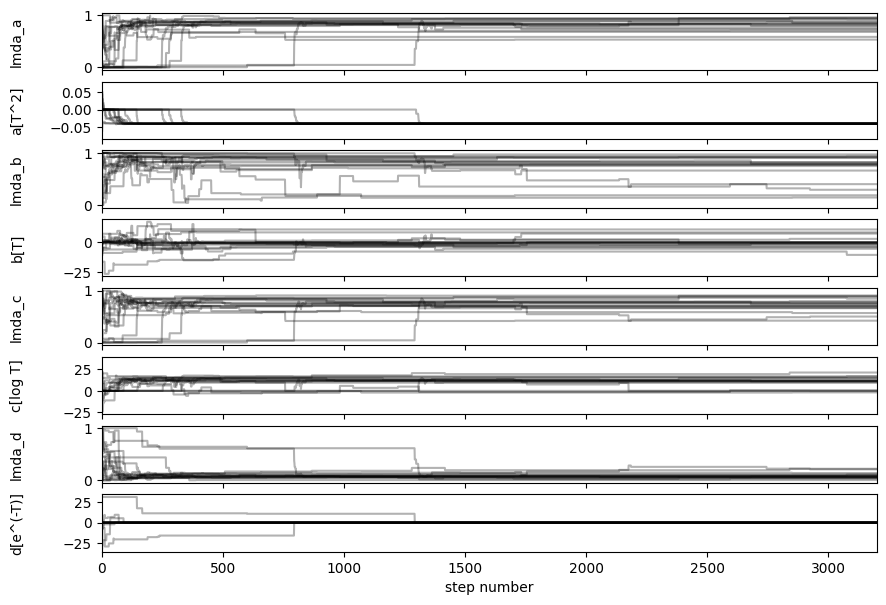

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
np.savetxt("posterior_spike_slab_all_larvar_3000", samples.reshape(samples.shape[0], -1), delimiter=",")
labels = json_object.get('MCMC').get('param_list') # Change the labels over here if changes in parameters are made in json file.
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [11]:
samples[-1,:,:]

array([[ 5.34117467e-01, -3.99815327e-02,  1.87671820e-01,
         0.00000000e+00,  4.22475336e-01,  0.00000000e+00,
         8.85058539e-02,  0.00000000e+00],
       [ 8.39330264e-01, -3.99710354e-02,  7.75646402e-01,
        -2.25101684e+00,  7.47516116e-01,  1.13105072e+01,
         8.13835268e-02,  0.00000000e+00],
       [ 8.35868588e-01, -3.99600266e-02,  8.19339379e-01,
        -3.57441140e+00,  7.77650351e-01,  1.16753274e+01,
         6.58789417e-02,  0.00000000e+00],
       [ 9.25142730e-01, -4.00012938e-02,  9.42927206e-01,
        -1.06170177e+01,  8.44496239e-01,  1.70191798e+01,
         1.08046108e-01,  0.00000000e+00],
       [ 7.99878835e-01, -3.99673844e-02,  7.94286264e-01,
        -9.99725050e-01,  7.36487422e-01,  1.11610629e+01,
         7.06857301e-02,  0.00000000e+00],
       [ 8.62647161e-01, -4.00109945e-02,  2.93603762e-01,
         0.00000000e+00,  5.01234529e-01, -2.72898739e-01,
         2.10504016e-01,  0.00000000e+00],
       [ 7.33649885e-01, -3.998636

  warnings.warn(



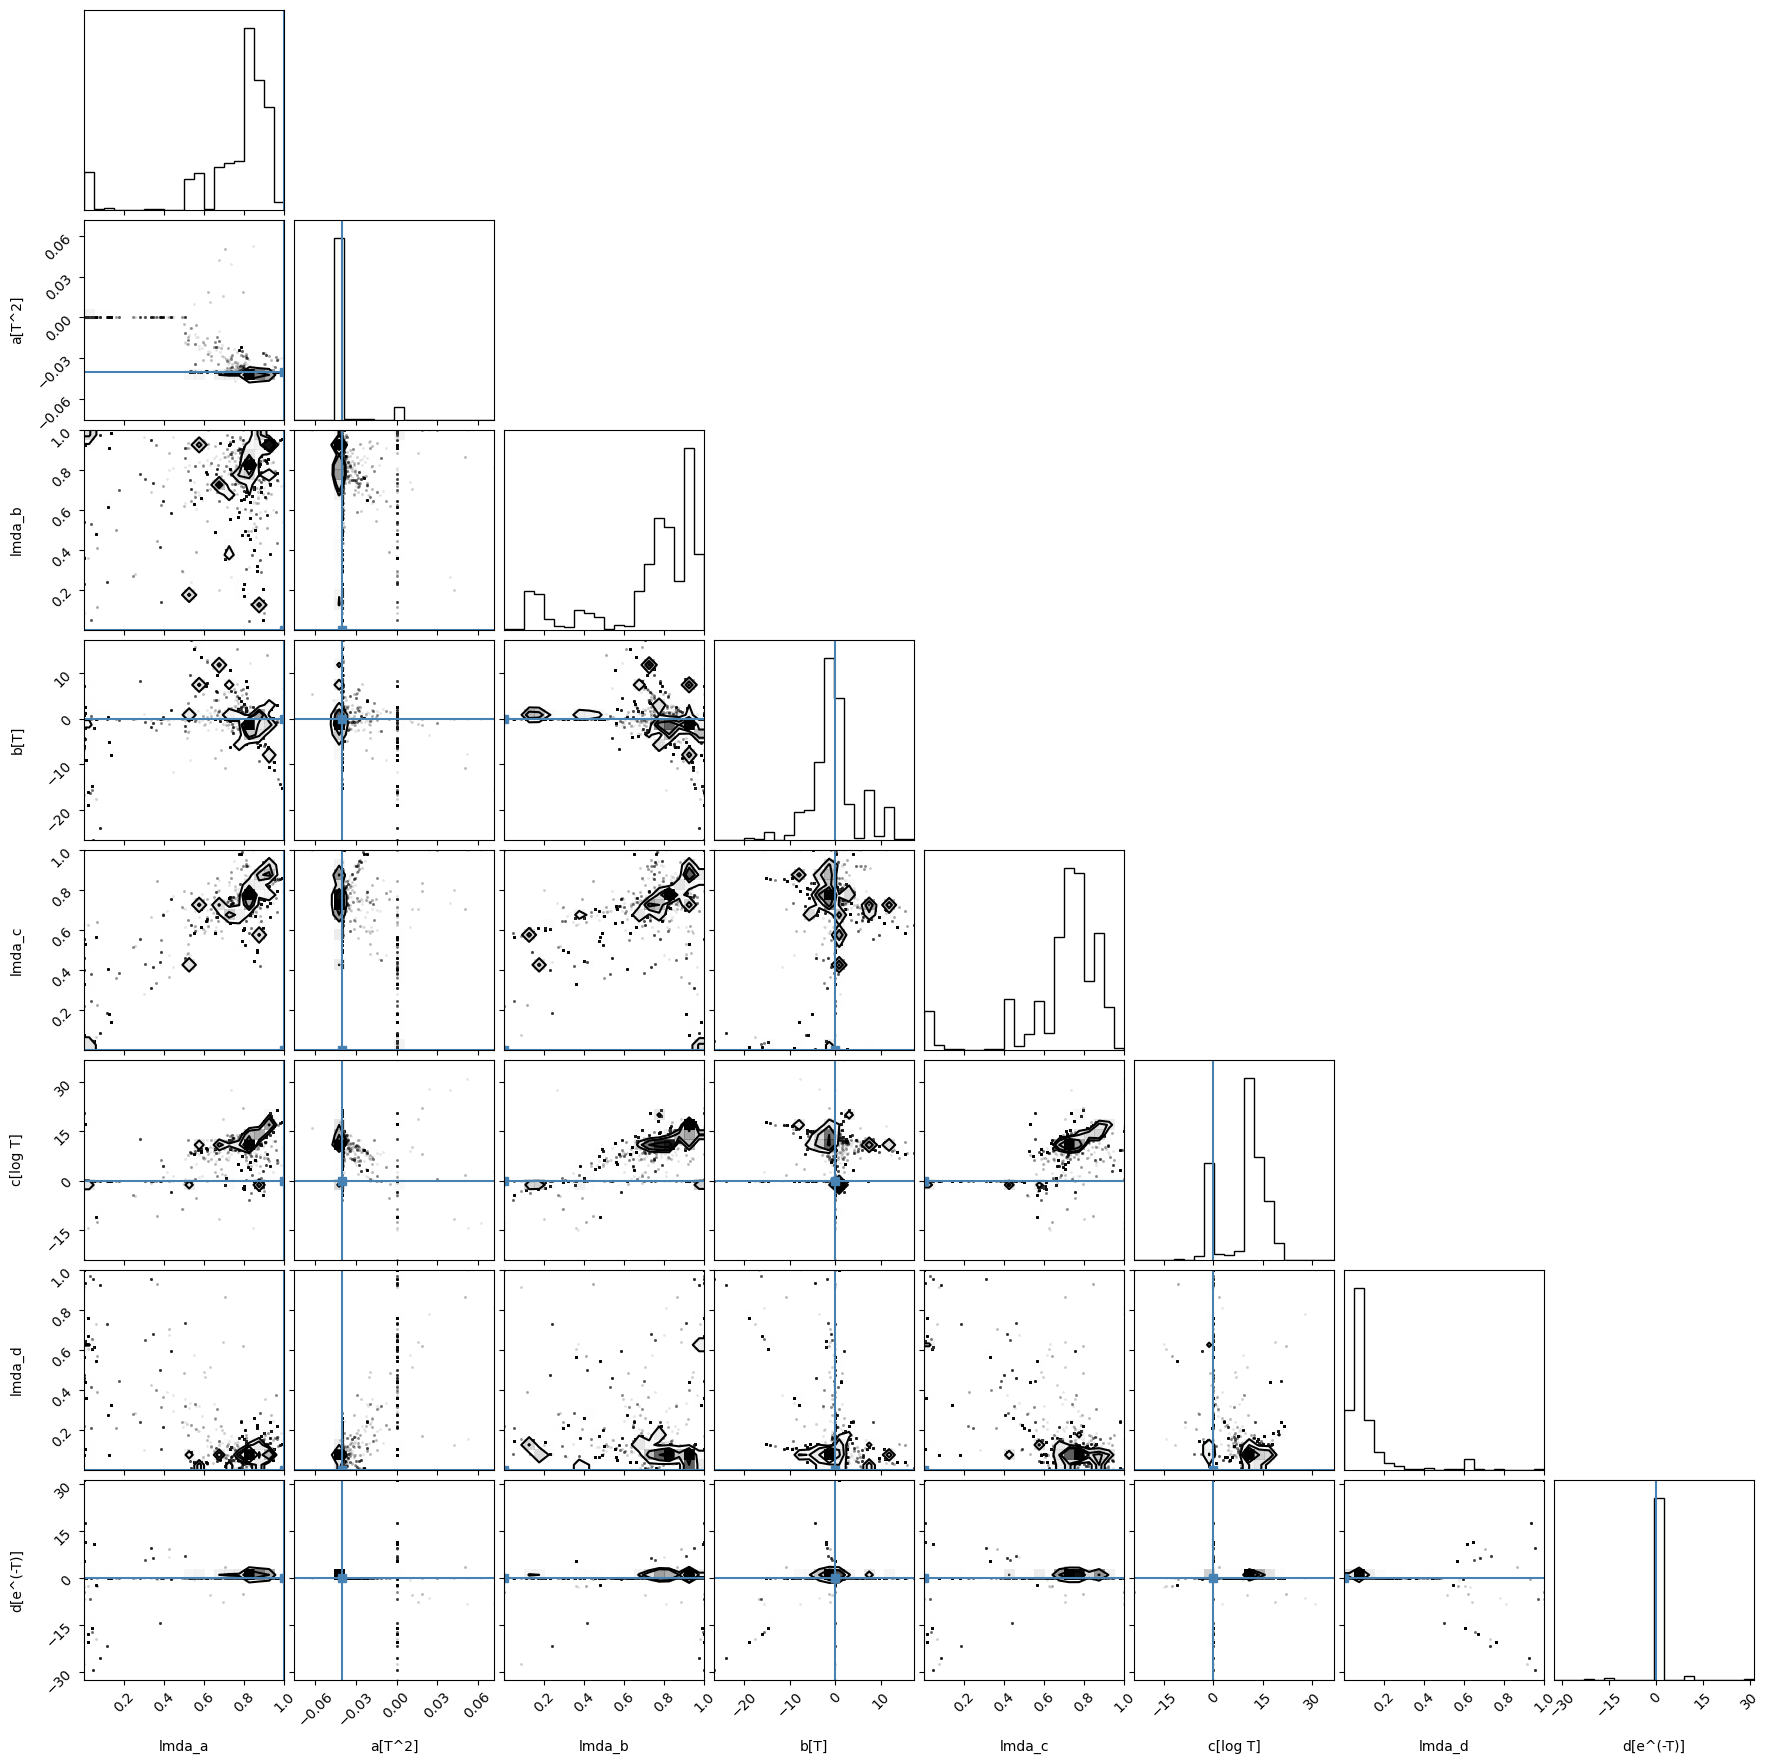

In [9]:

import corner
""" labels = ["lmbda_a", "a", "lmbda_b", "b", "lmbda_c", "c"]  # Change the labels over here if changes in parameters are made in json file.
fig = corner.corner(
    flat_samples, labels=labels, truths=[1, 235, 0, 0, 1, -0.04]
) """
# Change the labels over here if changes in parameters are made in json file.
fig = corner.corner(
    samples, labels=labels, truths=json_object.get('MCMC').get('true_values')
)


This part is for comparison with the other stored chains.

In [ ]:
import corner
""" labels = ["lmbda_a", "a", "lmbda_b", "b", "lmbda_c", "c"]  # Change the labels over here if changes in parameters are made in json file.
fig = corner.corner(
    flat_samples, labels=labels, truths=[1, 235, 0, 0, 1, -0.04]
) """
labels = ["lmda_a", "a[T^2]", "lmda_b", "b[T]", "lmda_c", "c[log T]", "lmda_d", "d[e^(-T)]"]  # Change the labels over here if changes in parameters are made in json file.
fig = corner.corner(
    posterior, labels=labels, truths=[0, 0.04, 0, 0, 0, 0, 0, 0]
)

In [ ]:
chain_data = np.loadtxt('posterior_spike_slab_5terms', delimiter=',')
posterior = chain_data.reshape(chain_data.shape[0], chain_data.shape[1]// ndim, ndim)
# chain_state/step number, chain_index, parameter_index
labels = ["lmda_a", "a[T^2]", "lmda_b", "b[T]", "lmda_c", "c[log T]", "lmda_d", "d[e^(-T)]"] 
posterior =posterior[:,:,:]
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
#labels = ["lmbda_a", "a", "lmbda_b", "b", "lmbda_c", "c"] # Change the labels over here if changes in parameters are made in json file.
for i in range(ndim):
    ax = axes[i]
    ax.plot(posterior[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(posterior))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
chain_data = np.loadtxt('posterior_spike_slab_5terms_25var', delimiter=',')
posterior = chain_data.reshape(chain_data.shape[0], chain_data.shape[1]// ndim, ndim)
# chain_state/step number, chain_index, parameter_index
labels = ["lmda_a", "a[T^2]", "lmda_b", "b[T]", "lmda_c", "c[log T]", "lmda_d", "d[e^(-T)]"] 
posterior =posterior[500:,:,:]
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
#labels = ["lmbda_a", "a", "lmbda_b", "b", "lmbda_c", "c"] # Change the labels over here if changes in parameters are made in json file.
for i in range(ndim):
    ax = axes[i]
    ax.plot(posterior[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(posterior))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")


In [ ]:
import corner
""" labels = ["lmbda_a", "a", "lmbda_b", "b", "lmbda_c", "c"]  # Change the labels over here if changes in parameters are made in json file.
fig = corner.corner(
    flat_samples, labels=labels, truths=[1, 235, 0, 0, 1, -0.04]
) """
labels = ["lmda_a", "a[T^2]", "lmda_b", "b[T]", "lmda_c", "c[log T]", "lmda_d", "d[e^(-T)]"]  # Change the labels over here if changes in parameters are made in json file.
fig = corner.corner(
    posterior, labels=labels, truths=[0, -0.04, 0, 0, 0, 0, 0, 0]
)


In [ ]:
np.log([23])

In [10]:
posterior[-1,:,:]

NameError: name 'posterior' is not defined

In [ ]:
#samples = sampler.get_chain(discard=1000, thin=15, flat=True)
sum(posterior[:,:,0] > 0.5)/500

In [ ]:
for i in posterior:
    for j in i:
        if j[0] < 0.5:
            j[0] = 0
        else:       
            j[0] = 1